In [98]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results, measure_smoothness_with_df
import torch
import torch.nn as nn


TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [99]:
TRAIN_PROPORTION = 0.9
MODE = "diff" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [100]:
data, all_gdps, all_gts = load_data()

In [101]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE,
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[],
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

X_train shape : (445, 180)
X_valid shape : (53, 180)
y_train shape : (445,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


## Simple Prediction Model

Using mps device


100%|██████████| 100/100 [00:00<00:00, 106.43it/s]


Final training loss: 0.01430259458720684
Final validation loss: 0.490361750125885
Final validation R^2: 0.34816100324288723


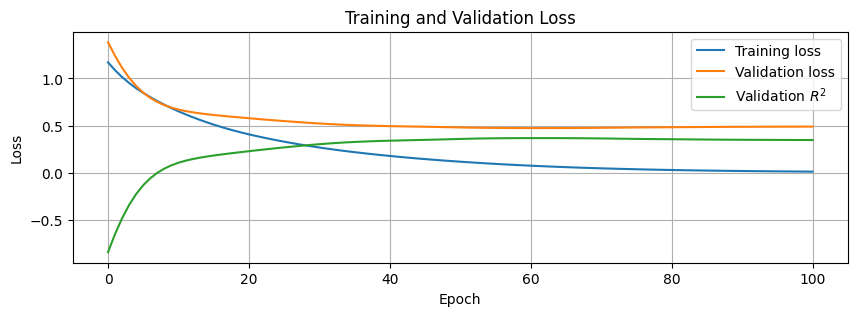

Best r squared: 0.3688724408374271 at epoch 60


In [102]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Compute best r squared with epoch
best_r_squared = max(validation_r_squared)
best_epoch = validation_r_squared.index(best_r_squared)

print(f"Best r squared: {best_r_squared} at epoch {best_epoch}")

## High frequency predictions

In [103]:
# Predict for the high frequency data
device = get_device(False)
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [104]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [105]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions = predictions.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

In [106]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    #plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [107]:
# Compute the smoothness of the predictions
predictions2 = predictions.copy()
predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results = measure_smoothness_with_df(predictions2)
print(f"Smoothness results: {smoothness_results}")

Smoothness results: [0.7242769460039438, 0.39359947561871766, 0.37404199892656986]


## Apply Data Augmentation

In [108]:
# For each data point, add a middle point with the average of the previous and next data points
# Modify X_train, y_train, X_valid, y_valid
X_train_smooth = []
y_train_smooth = []
X_valid_smooth = []
y_valid_smooth = []

countries = np.unique(country_train)
for country in countries:
    temp_X_train = X_train[country_train == country]
    temp_y_train = y_train[country_train == country]
    temp_dates = preprocessor.dates_train[country_train == country]
    for i in range(len(temp_X_train)):
        X_train_smooth.append(temp_X_train[i])
        y_train_smooth.append(temp_y_train[i])
        if i > 0:
            X_train_smooth.append((temp_X_train[i] + temp_X_train[i-1]) / 2)
            y_train_smooth.append((temp_y_train[i] + temp_y_train[i-1]) / 2)

X_train_smooth = np.array(X_train_smooth)
y_train_smooth = np.array(y_train_smooth)
X_valid_smooth = np.array(X_valid)
y_valid_smooth = np.array(y_valid)


In [109]:
# Print the shapes of the new data
print(f"X_train_smooth shape: {X_train_smooth.shape} - Original shape: {X_train.shape}")
print(f"y_train_smooth shape: {y_train_smooth.shape} - Original shape: {y_train.shape}")
print(f"X_valid_smooth shape: {X_valid_smooth.shape} - Original shape: {X_valid.shape}")
print(f"y_valid_smooth shape: {y_valid_smooth.shape} - Original shape: {y_valid.shape}")

X_train_smooth shape: (883, 180) - Original shape: (445, 180)
y_train_smooth shape: (883,) - Original shape: (445,)
X_valid_smooth shape: (53, 180) - Original shape: (53, 180)
y_valid_smooth shape: (53,) - Original shape: (53,)


Using mps device


100%|██████████| 100/100 [00:00<00:00, 118.40it/s]

Final training loss: 0.020117538049817085
Final validation loss: 0.5099011063575745
Final validation R^2: 0.322187377915384


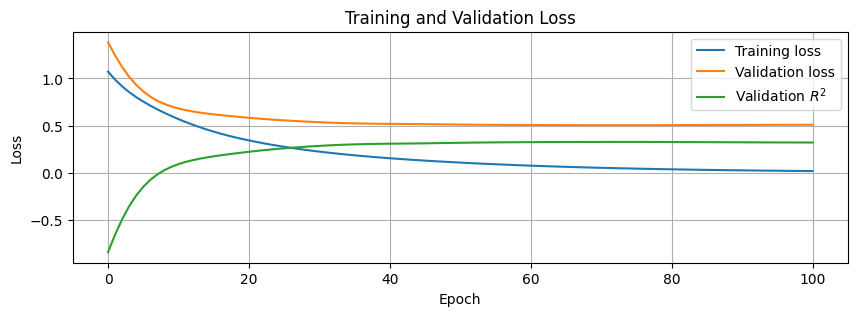

In [110]:
# Train the model with the new data
model_smooth, training_loss_smooth, validation_loss_smooth, validation_r_squared_smooth, mse_losses_smooth = train_nn(X_train_smooth, 
                                                                                                                   y_train_smooth, 
                                                                                                                   X_valid_smooth, 
                                                                                                                   y_valid_smooth, 
                                                                                                                   num_epochs=100, 
                                                                                                                   learning_rate=1e-4, 
                                                                                                                   weight_decay=1e-2, 
                                                                                                                   verbose=True,
                                                                                                                   seed=SEED)

In [111]:
# Compute best r squared with epoch
best_r_squared_smooth = max(validation_r_squared_smooth)
best_epoch_smooth = validation_r_squared_smooth.index(best_r_squared_smooth)

print(f"Best r squared: {best_r_squared_smooth} at epoch {best_epoch_smooth}")

Best r squared: 0.32844274418408603 at epoch 74


In [112]:
# Compute the predictions for the high frequency data
y_pred_high_freq_smooth = model_smooth(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country_smooth = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq_smooth})

# Set the predicions to be plotted
predictions_smooth = y_pred_high_freq_country_smooth

# Add the true gdp for the points that we have
predictions_smooth = predictions_smooth.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions_smooth = predictions_smooth.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions_smooth = predictions_smooth.rename(columns={"y_pred": "y_pred_high_freq"})
predictions_smooth2 = predictions_smooth.copy()
predictions_smooth2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results_adjusted = measure_smoothness_with_df(predictions_smooth2)
print(f"Smoothness results: {smoothness_results_adjusted}")

Smoothness results: [0.6872509605427771, 0.37931706454833264, 0.37547946287775]


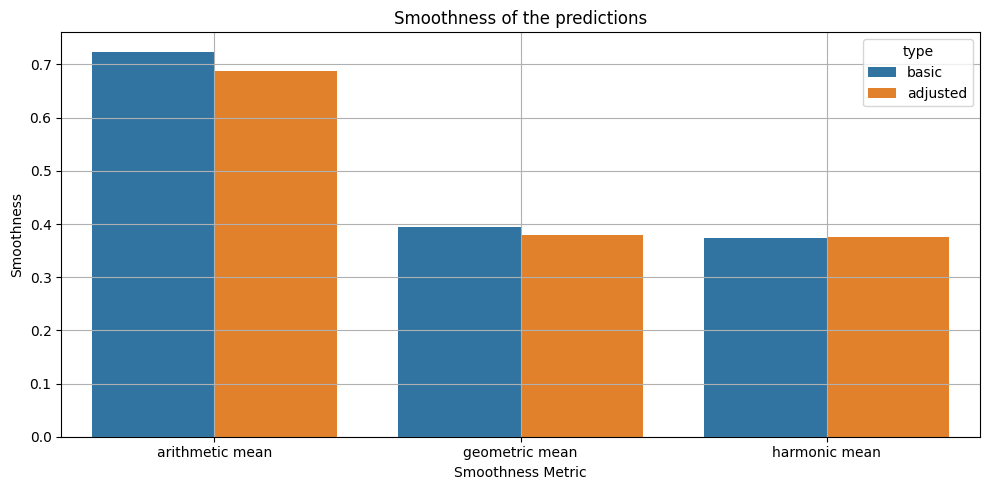

Smoothness ratios: [1.0538754946692606, 1.037652962139712, 0.9961716575917011]


In [113]:
# Plot the results between the basic and adjusted predictions
all_smoothness_results = pd.DataFrame({'basic': smoothness_results, 'adjusted': smoothness_results_adjusted})
metrics = ['arithmetic mean', 'geometric mean', 'harmonic mean']

# Melting the dataframe
all_smoothness_results = all_smoothness_results.reset_index().melt(id_vars='index', var_name='type', value_name='smoothness')
all_smoothness_results['index'] = all_smoothness_results['index'].apply(lambda x: metrics[x])

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x='index', y='smoothness', hue='type', data=all_smoothness_results)
plt.title("Smoothness of the predictions")
plt.xlabel("Smoothness Metric")
plt.ylabel("Smoothness")
plt.grid(True)
plt.tight_layout()
plt.show()
# Difference between the smoothness results
percentage_ratios = [smoothness_results[i] / smoothness_results_adjusted[i] for i in range(len(smoothness_results))]
print(f"Smoothness ratios: {percentage_ratios}")